<a href="https://colab.research.google.com/github/PhDSGilber/Autoencoders/blob/main/Autoendores_function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LAB 2.2 - Sparse Autoencoders

In [1]:
!wget -nc --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2021.deeplearning/main/content/init.py
import init; init.init(force_download=False); init.get_weblink()

replicating local resources


## LAB SUMMARY

In this lab we will create a **Sparse Autoencoder**, where we will force the encoder to have **SMALL ACTIVATIONS**. we will continue to use **MNIST**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.datasets import mnist
import tensorflow as tf

%matplotlib inline

In [3]:
mnist = pd.read_csv("local/data/mnist1.5k.csv.gz", compression="gzip", header=None).values

X=(mnist[:,1:785]/255.).astype(np.float32)
y=(mnist[:,0]).astype(int)
print("dimension de las imagenes y las clases", X.shape, y.shape)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

dimension de las imagenes y las clases (1500, 784) (1500,)
(1200, 784) (1200,) (300, 784) (300,)


## TASK 01: Handcrafted sparse autoencoder


Given:

- input $X_{in} \in \mathbb{R}^{m\times n}$ = $\{ x^{(0)}, x^{(1)},..., x^{(m-1)}  \}$, with $x^{(i)}  \in \mathbb{R}^n$

- encoder weights and bias: $W_e \in \mathbb{R}^{n \times c}$, $b_e \in \mathbb{R}^{c}$
- decoder weights and bias: $W_d \in \mathbb{R}^{c \times n}$, $b_d \in \mathbb{R}^{n}$

with:

- $n$ the input data dimension
- $m$ the number of input data items
- $c$ the autoencoder `code_size`

An autoencoder output is computed as a regular neural network

$$X_{out} = d(e(X_{in})) = \sigma(\text{r}(X_{in} \times W_e + b_e) \times W_d  + b_d)$$

where:

- $X_{out} \in \mathbb{R}^{m\times n}$ is the output
- $d(X) = \sigma(X \times W_d  + b_d)$ is the decoder function
- $e(X) = \text{r}(X \times W_e + b_e)$ is the encoder function
- $\sigma(z) = 1/(1+e^{-z})$ is the sigmoid activation function
- $r(z) = \text{max}(0, z)$ is the ReLU activation function

and we use the following loss function

$$\text{loss}(X_{in}) = \frac{1}{mn}\sum_{m,n} \big(x^{(i)} - d(e(x^{(i)}))\big)^2 + \beta \frac{1}{mc}\sum_{m,c} e(x^{(i)})$$

observe that:

- we pretend to penalize large values of the encoder activations, with $\beta$ regulating how much we penalize
- as we are using ReLU there is no need to square $e(x^{(i)})$
- the summations are over the number of elements ($m$, with the running index $i \in [0,..,m-1]$) **and** the number of columns ($n$ for the first term, $c$ for the second term)


**Complete the following function to compute the encoder output and loss**. All arguments are `numpy` arrays. The `Xout` output must also be a `numpy` array and `loss` must be a number. You cannot use Tensorflow to implement your function.


In [4]:
def apply_autoencoder(Xin, We, be, Wd, bd, beta=0.05):

    sigm = lambda z: 1/(1+np.exp(-z))
    relu = lambda z: z*(z>0)

    e = relu(np.matmul(Xin,We) + be)
    d = sigm(np.matmul(e,Wd) + bd)


    Xout = d
    n = Xin.shape[1]
    m = Xin.shape[0]
    c = be.shape[0]

    loss = (1/(m*n))*(np.sum(((Xin-Xout)**2))) + beta*(1/(m*c))*(np.sum(e))

    return Xout, loss

test your code

In [5]:
#
# --- you should get the following output up to three decimals ---
#
# Xout
#  [[0.53992624 0.54127547 0.40167658 0.59832582]
#  [0.580101   0.55012488 0.42321322 0.59509962]
#  [0.62155216 0.52174768 0.43006826 0.62407879]
#  [0.55635373 0.54059637 0.40857522 0.60072369]
#  [0.62178687 0.51694816 0.42812613 0.62813387]]
# loss
#  0.5723349282191469

Xin = np.array([[-0.37035694, -0.34542735,  0.15605706, -0.33053004],
                [-0.3153002 , -0.41249585,  0.30073246,  0.13771319],
                [-0.30017424, -0.15409659, -0.43102843,  0.38578104],
                [-0.14914677, -0.4411987 , -0.33116959, -0.32483895],
                [-0.17407847,  0.0946155 , -0.48391975,  0.34075492]])

We = np.array([[-0.28030543, -0.46140969, -0.18068483],
               [ 0.31530074,  0.29354581, -0.30835241],
               [-0.35849794, -0.12389752, -0.01763293],
               [ 0.44245022, -0.4465276 , -0.40293482]])

be = np.array([ 0.33030961,  0.33221543, -0.32828997])

Wd = np.array([[ 0.42964391, -0.22892199,  0.09340045,  0.25372971],
               [-0.41209546, -0.23107885, -0.28591832,  0.15998353],
               [-0.16731707, -0.10630373, -0.15786946, -0.20899463]])

bd = np.array([ 0.32558449,  0.31610265, -0.25844944,  0.28249571])

Xout, loss = apply_autoencoder(Xin, We, be, Wd, bd)

print ("Xout\n", Xout)
print ("loss\n", loss)

Xout
 [[0.53992624 0.54127547 0.40167658 0.59832582]
 [0.580101   0.55012488 0.42321322 0.59509962]
 [0.62155216 0.52174768 0.43006826 0.62407879]
 [0.55635373 0.54059637 0.40857522 0.60072369]
 [0.62178687 0.51694816 0.42812613 0.62813387]]
loss
 0.5723349282191469


Try your code with other cases

In [61]:
n,m,c = 4, 5, 3

Xin = np.random.random(size=(m,n))-.5
We  = np.random.random(size=(n,c))-.5
be  = np.random.random(size=c)-.5

Wd  = np.random.random(size=(c,n))-.5
bd  = np.random.random(size=n)-.5

Xout, loss = apply_autoencoder(Xin, We, be, Wd, bd)

print ("Xout\n", Xout)
print ("loss\n", loss)

Xout
 [[0.41064693 0.48673588 0.39326929 0.5688882 ]
 [0.41064693 0.48673588 0.39326929 0.5688882 ]
 [0.44317691 0.45607877 0.36493738 0.53909055]
 [0.41064693 0.48673588 0.39326929 0.5688882 ]
 [0.41064693 0.48673588 0.39326929 0.5688882 ]]
loss
 0.4397851516876518


## TASK 02: Sparse autoencoder model

Complete the `get_model` function so that the returned model uses the loss function previously defined.

You **MUST USE** the **UNSUPERVISED** method to specify your loss function as described in the notes, so that the `.fit` method only gets one argument.


Note for models you have to use **Tensorflow operations** in specific you have to use [`tf.reduce_mean`](https://www.tensorflow.org/api_docs/python/tf/math/reduce_mean)

In [66]:
def get_model(input_dim, code_size,beta=.01): #We,be,Wd,bd,
    from tensorflow.keras import Sequential, Model
    from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
    import tensorflow as tf

    inputs = Input(shape=input_dim, name="input")
    encoder = Dense(code_size, activation='relu', name="encoder")(inputs)
    outputs = Dense(input_dim, activation='sigmoid', name="decoder")(encoder)


    n = input_dim
    m = inputs.shape[0]
    c = code_size

    loss = (1/n)*(tf.reduce_sum((tf.reduce_mean((inputs-outputs)**2,0))))+ beta*(1/c)*(tf.reduce_sum((tf.reduce_mean(encoder,0))))


    model = Model([inputs], [outputs])
    model.add_loss(loss)

    # for layer in model.layers:
    #   if layer.name == 'encoder':
    #     layer.set_weights([We,be])
    #   elif layer.name == 'decoder':
    #     layer.set_weights([Wd,bd])

    model.compile(optimizer='adam')
    return model

to manually check your code verify that you get the same results with your model and with the function from previous exercise. Observe the possible difference in number precisions (32 vs 64 bits)

In [67]:
def get_loss(model, Xinput):
    input_layer = model.get_layer("input")
    loss_layer = model.get_layer([i.name for i in model.layers if i.name.startswith("add_loss")][0])
    ml = Model(input_layer.input, loss_layer.output)
    return (ml(Xinput).numpy())

model = get_model(input_dim=X.shape[1], code_size=50, beta=0.05)
print (model(X_train).numpy())
print (get_loss(model, X_train))

[[0.5173564  0.5183012  0.49240276 ... 0.49653518 0.5151029  0.5527207 ]
 [0.47918797 0.49521238 0.5038863  ... 0.4957276  0.5015893  0.49677163]
 [0.49904758 0.47575858 0.5281472  ... 0.49451017 0.50514156 0.5470305 ]
 ...
 [0.47991294 0.4755671  0.5556597  ... 0.5068373  0.51774436 0.51302093]
 [0.50690264 0.51233506 0.495776   ... 0.50104344 0.49733433 0.5046095 ]
 [0.49552578 0.48989666 0.4980998  ... 0.5136003  0.50422376 0.50614136]]
180.9631


In [62]:
# output and loss from TF model in this task
def get_loss(model, Xinput):
    input_layer = model.get_layer("input")
    loss_layer = model.get_layer([i.name for i in model.layers if i.name.startswith("add_loss")][0])
    ml = Model(input_layer.input, loss_layer.output)
    return (ml(Xinput).numpy())

model = get_model(input_dim=X.shape[1], code_size=50, beta=0.05)
print (model(X_train).numpy())
print (get_loss(model, X_train))


[[0.4787136  0.49306235 0.47258142 ... 0.46734014 0.48439205 0.4937854 ]
 [0.46073845 0.50818294 0.4744916  ... 0.48240224 0.4276219  0.4537023 ]
 [0.47227365 0.52451783 0.47634852 ... 0.4620971  0.49768516 0.5103933 ]
 ...
 [0.43704218 0.481829   0.5134117  ... 0.48057875 0.51835227 0.49096322]
 [0.49272546 0.49879703 0.4881195  ... 0.48534894 0.45771685 0.47304407]
 [0.46861184 0.5122525  0.477307   ... 0.47948924 0.46275574 0.4597193 ]]
0.24092297


In [63]:
# output and loss from previous task
We, be, Wd, wd = model.get_weights()
Xout, loss = apply_autoencoder(X_train, We, be, Wd, wd, beta=0.05)
print(Xout)
print(loss)

[[0.47871363 0.49306235 0.47258145 ... 0.46734014 0.48439202 0.49378538]
 [0.46073845 0.5081829  0.4744916  ... 0.48240224 0.42762193 0.45370224]
 [0.47227368 0.5245178  0.47634852 ... 0.4620971  0.49768516 0.5103933 ]
 ...
 [0.43704224 0.481829   0.51341176 ... 0.48057875 0.51835227 0.49096325]
 [0.4927255  0.49879697 0.48811957 ... 0.48534894 0.45771682 0.47304407]
 [0.46861178 0.5122525  0.47730696 ... 0.47948927 0.46275577 0.45971927]]
0.24092295632706207


you can now train the autoencoder and check its behavior

In [70]:
model.fit(X_train, epochs=500, batch_size=32)

Epoch 1/500
38/38 [==============================] - 1s 3ms/step - loss: 105.7243
Epoch 2/500
38/38 [==============================] - 0s 3ms/step - loss: 59.8837
Epoch 3/500
38/38 [==============================] - 0s 3ms/step - loss: 52.0506
Epoch 4/500
38/38 [==============================] - 0s 3ms/step - loss: 45.4271
Epoch 5/500
38/38 [==============================] - 0s 4ms/step - loss: 40.7988
Epoch 6/500
38/38 [==============================] - 0s 3ms/step - loss: 37.4130
Epoch 7/500
38/38 [==============================] - 0s 3ms/step - loss: 34.8891
Epoch 8/500
38/38 [==============================] - 0s 3ms/step - loss: 32.8907
Epoch 9/500
38/38 [==============================] - 0s 3ms/step - loss: 31.3004
Epoch 10/500
38/38 [==============================] - 0s 3ms/step - loss: 29.9733
Epoch 11/500
38/38 [==============================] - 0s 3ms/step - loss: 28.6320
Epoch 12/500
38/38 [==============================] - 0s 3ms/step - loss: 27.4828
Epoch 13/500
38/38 [====

###  test the reconstruction

1/1 [==============================] - 0s 67ms/step


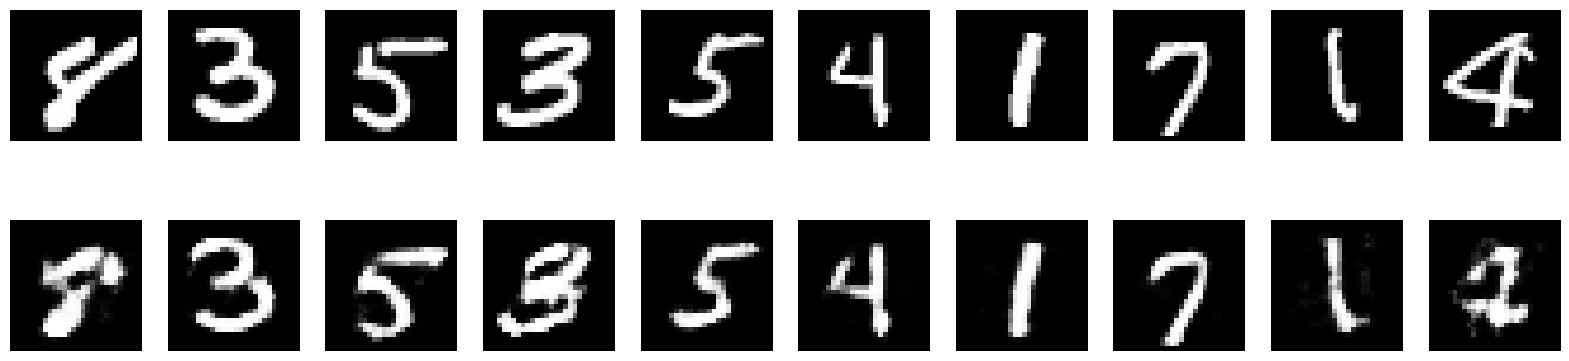

In [73]:
X_sample = X_test[:10]
X_pred   = model.predict(X_sample)

plt.figure(figsize=(20,5))
for i in range(len(X_sample)):
    plt.subplot(2,len(X_sample),i+1)
    plt.imshow(X_sample[i].reshape(28,28), cmap=plt.cm.Greys_r)
    plt.axis("off")
    plt.subplot(2,len(X_sample),len(X_sample)+i+1)
    plt.imshow(X_pred[i].reshape(28,28), cmap=plt.cm.Greys_r)
    plt.axis("off")

### In a similar fashion to the corresponding course ntoes, you can inspect the encoder and decoder weights, and also the activations and distributions in the latent space. For activations you should get something similar to this, indicating a much more sparse representation

encoded data size (200, 50)
mean activation at encoder 0.173


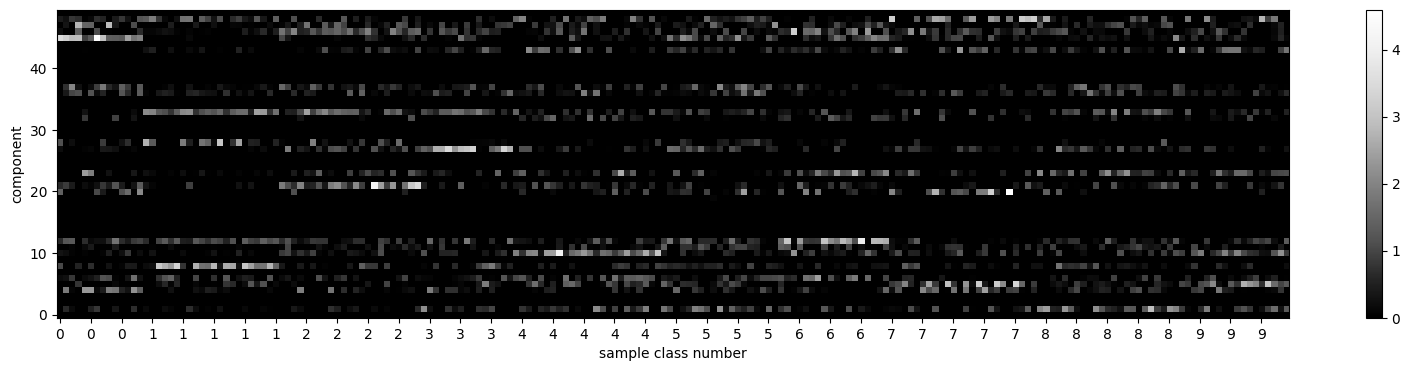

In [74]:
idxs = np.random.permutation(len(X_test))[:200]
idxs = idxs[np.argsort(y_test[idxs])]
y_sample = y_test[idxs]
X_sample = X_test[idxs]

X_sample_encoded = me([X_sample]).numpy()
print("encoded data size", X_sample_encoded.shape)
plt.figure(figsize=(20,4))
plt.imshow(X_sample_encoded.T, cmap=plt.cm.Greys_r, origin="lower")
plt.colorbar()
plt.ylabel("component")
plt.xlabel("sample class number")
plt.xticks(range(len(y_sample))[::5], y_sample[::5]);
print ("mean activation at encoder %.3f"%np.mean(X_sample_encoded))

### **indicating most activations are now very close to zero**

In [75]:
layer_input   = model.get_layer("input")
layer_encoder = model.get_layer("encoder")

me = Model([layer_input.input], [layer_encoder.output])
me(X_train)

<tf.Tensor: shape=(1200, 50), dtype=float32, numpy=
array([[0.13597485, 0.        , 2.0675213 , ..., 0.7613442 , 0.25889447,
        1.4528141 ],
       [0.49542496, 0.        , 0.        , ..., 0.        , 1.5653188 ,
        0.5569937 ],
       [0.        , 0.        , 1.6223047 , ..., 1.1365333 , 0.4815719 ,
        1.8189075 ],
       ...,
       [0.98293686, 0.54243565, 0.06412005, ..., 0.7232316 , 0.        ,
        0.        ],
       [0.11068007, 1.4877181 , 0.        , ..., 1.6305926 , 0.39685476,
        0.41761556],
       [0.63359714, 0.5321939 , 0.08921742, ..., 0.565585  , 1.5279144 ,
        0.54845214]], dtype=float32)>

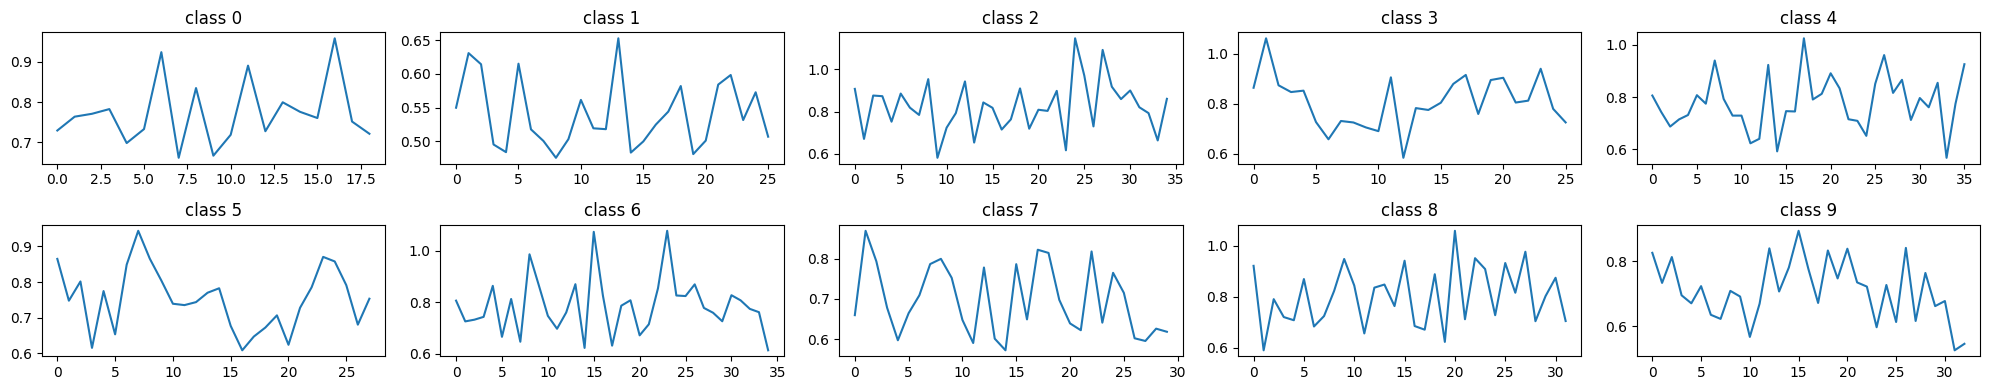

In [76]:
e = me(X_test).numpy()

plt.figure(figsize=(20,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.plot(e[y_test==i].mean(axis=1))
    plt.title(f"class {i}")
plt.tight_layout()

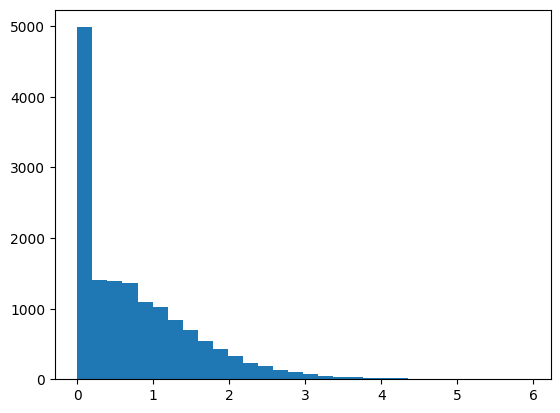

In [77]:
plt.hist(e.flatten(), bins=30);

### And you should see some latent neurons **got specialized** when inspecting the decoder weights

In [78]:
def show_img_grid(w):
    plt.figure(figsize=(10,10))
    for k,wi in enumerate(w):
        plt.subplot(10,10,k+1)
        plt.imshow(wi.reshape(28,28), cmap=plt.cm.Greys_r)
        plt.axis("off")

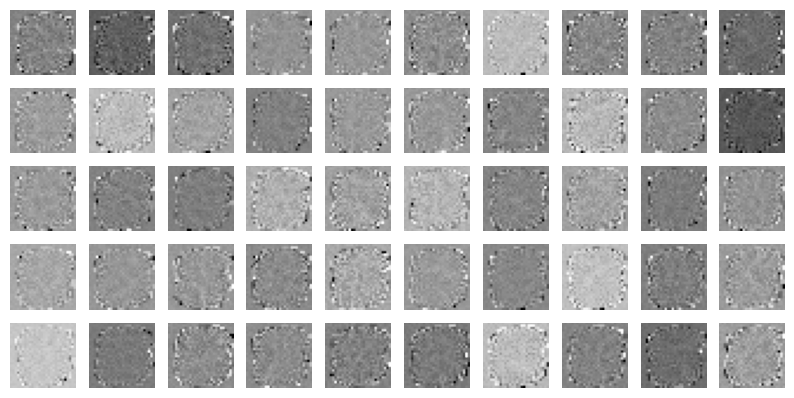

In [79]:
show_img_grid(model.get_layer("encoder").weights[0].numpy().T)

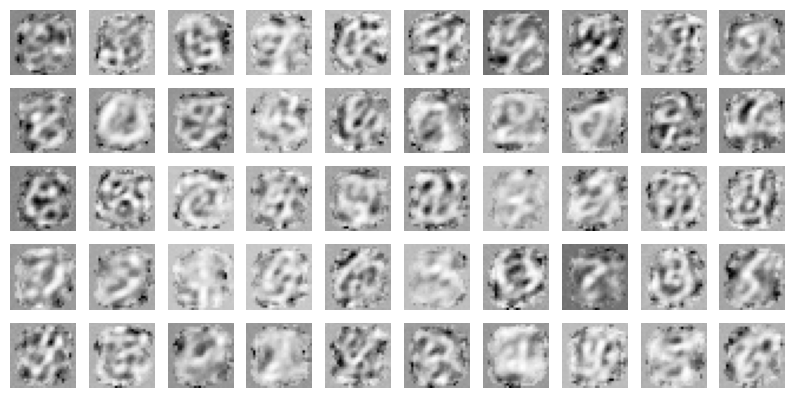

In [80]:
show_img_grid(model.get_layer("decoder").weights[0].numpy())